## TRAINING WITH THE GIVEN IMAGES

In [2]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D , BatchNormalization , MaxPooling2D,UpSampling2D
from keras import Model,Input
from keras.optimizers import adam_v2
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
import pickle

#### Creating a data frame using image paths and the label

In [3]:
train_data = pd.DataFrame(columns=['Image_src','Label'])
for i in range(8):
    train_data.loc[i,'Image_src']= 'ai_coding_test-main/train/'+ os.listdir('ai_coding_test-main/train/')[i]
    train_data.loc[i,'Label']='Apple'
train_data.head()

,Image_src,Label
0,ai_coding_test-main/train/apple_1.png,Apple
1,ai_coding_test-main/train/apple_2.png,Apple
2,ai_coding_test-main/train/apple_3.png,Apple
3,ai_coding_test-main/train/apple_4.png,Apple
4,ai_coding_test-main/train/apple_5.png,Apple


### Processing the image


- Resizing the image 
- Normalizing the pixels 
- Storing them in an array


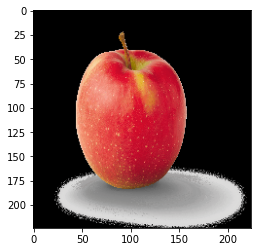

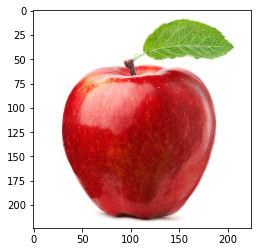

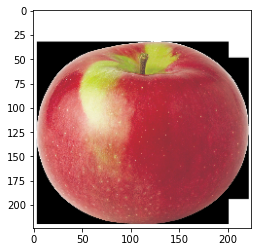

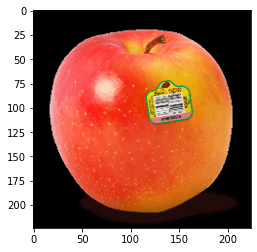

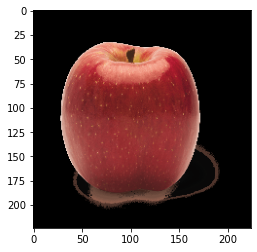

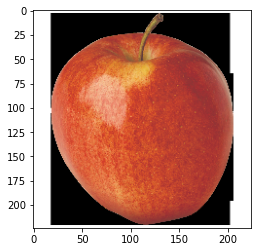

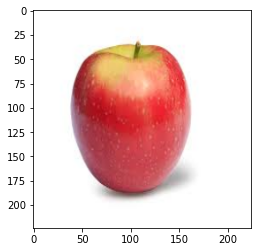

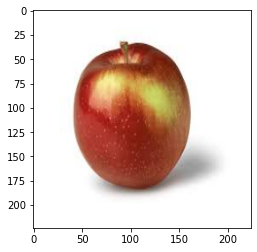

In [4]:


train_img=[]
for i in range(len(train_data)):
    img = cv2.imread(train_data.iloc[i,0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img , (224,224))
    #plt.imshow(img)
   
    img_array = np.array(img,dtype=np.float32)
    img_array /= 255.0
    
    plt.imshow(img_array)
    plt.show()
    train_img.append(img_array)
train_img=np.array(train_img)

### Developing AutoEncoder Model 


- Autoencoders will help in extracting features from the input images .
- Here I have encoded the input images to maximum 256 features .
- I will be extracting the features from these encoded images.


In [ ]:



input_img = Input(shape=(224, 224, 3))

encoded_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
encoded_2 = MaxPooling2D((2, 2), padding='same')(encoded_1)
encoded_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_2)

encoded_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_3)
encoded_5 = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded_4)
encoded = MaxPooling2D((2, 2), padding='same')(encoded_5)


x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu',padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
print(autoencoder.summary())



In [8]:
opt = adam_v2.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=8, min_lr=0.0001,verbose=2)
model_checkpoint = ModelCheckpoint(
    filepath='best_model.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,verbose =1)

In [9]:
# Training the model 
history = autoencoder.fit(train_img, train_img,
                epochs=50,
                batch_size=2,
                shuffle=True,
                validation_split=0.2,
                callbacks=[reduce_lr,model_checkpoint]
                )

Epoch 1/50
3/3 [==============================] - 14s 4s/step - loss: 0.0661 - val_loss: 0.1819

Epoch 00001: val_loss improved from inf to 0.18187, saving model to best_model.hdf5
Epoch 2/50
3/3 [==============================] - 13s 5s/step - loss: 0.0564 - val_loss: 0.1442

Epoch 00002: val_loss improved from 0.18187 to 0.14420, saving model to best_model.hdf5
Epoch 3/50
3/3 [==============================] - 12s 4s/step - loss: 0.0623 - val_loss: 0.1409

Epoch 00003: val_loss improved from 0.14420 to 0.14095, saving model to best_model.hdf5
Epoch 4/50
3/3 [==============================] - 12s 4s/step - loss: 0.0551 - val_loss: 0.1514

Epoch 00004: val_loss did not improve from 0.14095
Epoch 5/50
3/3 [==============================] - 13s 5s/step - loss: 0.0640 - val_loss: 0.1537

Epoch 00005: val_loss did not improve from 0.14095
Epoch 6/50
3/3 [==============================] - 13s 4s/step - loss: 0.0589 - val_loss: 0.1398

Epoch 00006: val_loss improved from 0.14095 to 0.13981, 

3/3 [==============================] - 13s 4s/step - loss: 0.0052 - val_loss: 0.0028

Epoch 00050: val_loss did not improve from 0.00267


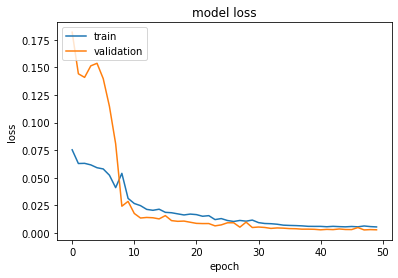

In [10]:
# Plotting the train and test Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The model achieved only 0.2% test loss , so it has been trained well.  

In [5]:

autoencoder = load_model('best_model.hdf5')
opt = adam_v2.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')

### Feature Extraction 

#### Selection of the encoded layer to extract features
- I have used each encoder layer to calculate standard deviation of the n features encoded in that layer
- Then I have displayed all the train images to select the best layer
- I observe that the encoded_5 layer has all the features clearly marking the edges,curves and shadows .
- So I will select that layer for feature extraction

encoded_1


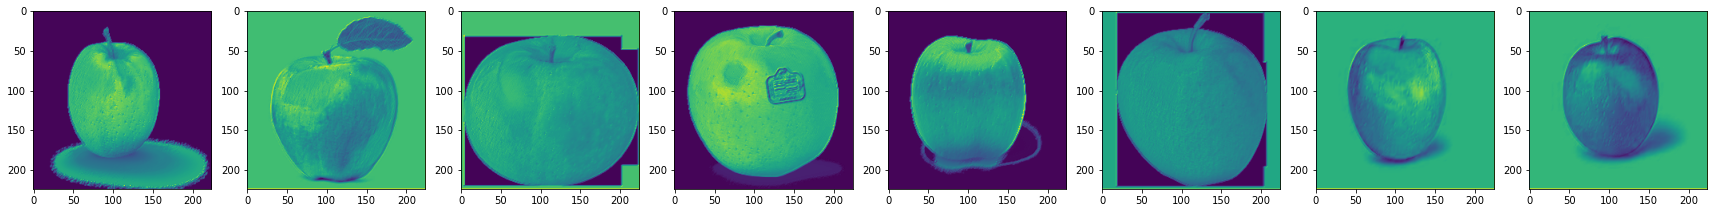

encoded_2


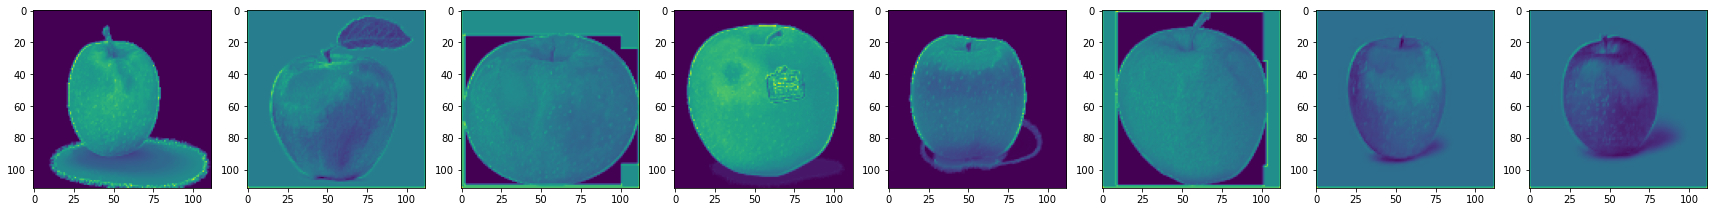

encoded_3


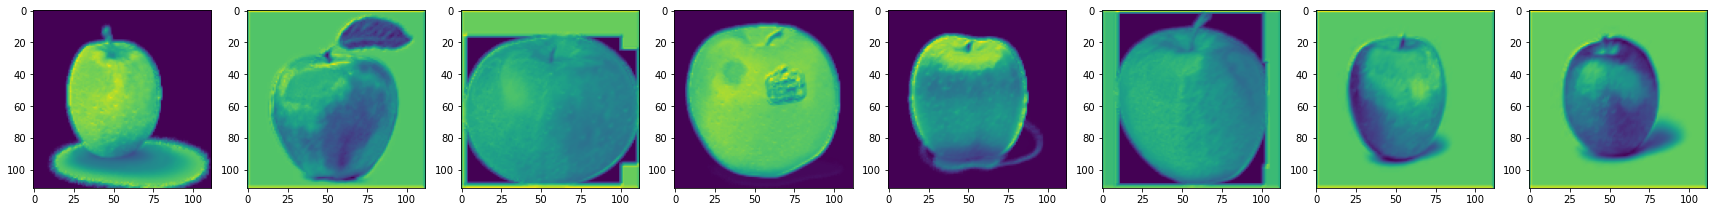

encoded_4


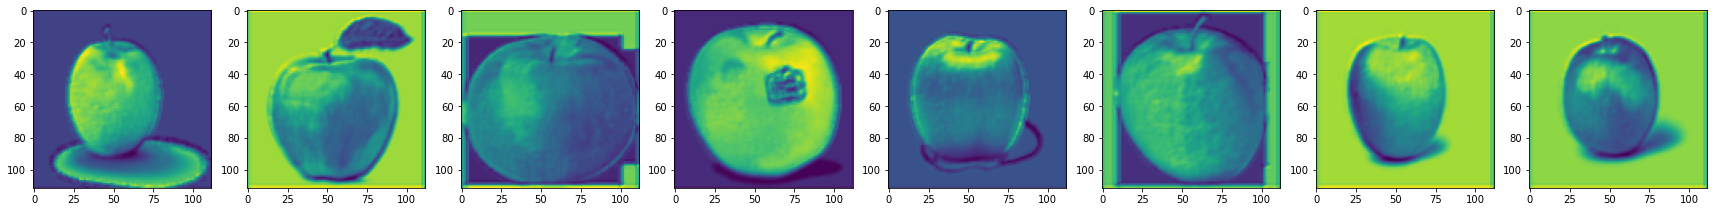

encoded_5


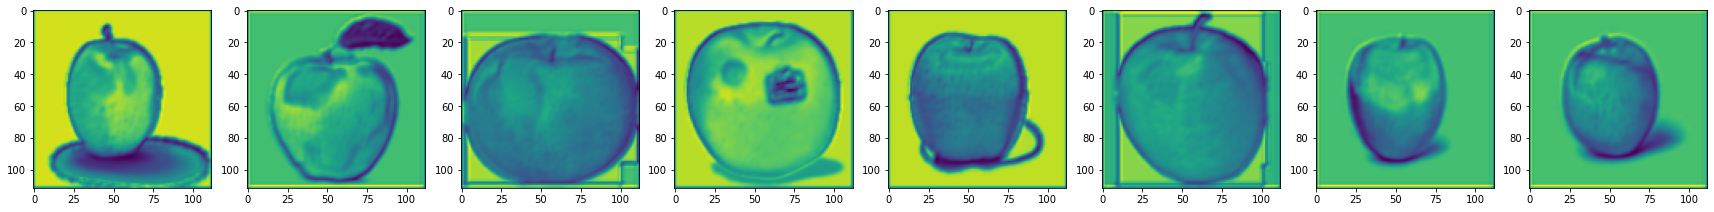

encoded


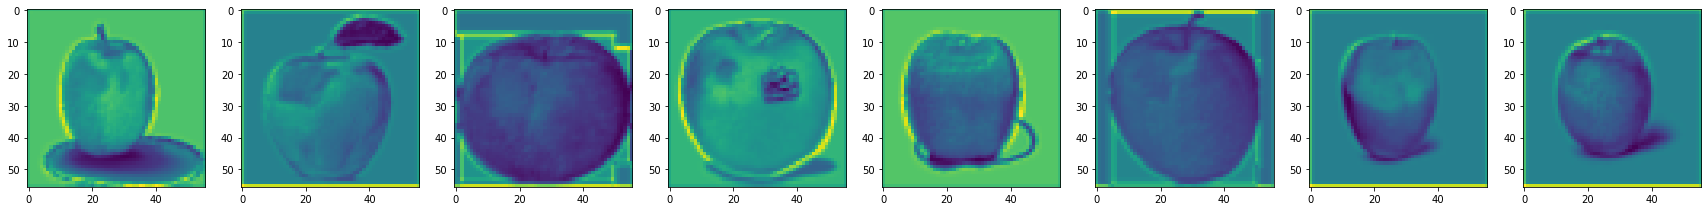

In [33]:
layer_name = ['encoded_1','encoded_2','encoded_3','encoded_4','encoded_5','encoded']
j=0
for k in range(1,len(layer_name)+1):
    print(layer_name[j])
    
    encoder = Model([autoencoder.layers[0].input], [autoencoder.layers[k].output])
    encoded_imgs = encoder.predict(train_img)
    plt.figure(figsize=(30,30))
    for i in range(len(encoded_imgs)):
        
        plt.subplot(1,8,i+1)
        img=encoded_imgs[i].mean(axis=-1)
        plt.imshow(img)
    plt.show()
    j+=1

In [35]:
#generating features
def generate_feat(encoder_layer,input_layer,imgs):
    encoder = Model(input_layer,encoder_layer)
    encoded_imgs = encoder.predict(imgs)
    encoded_img=[]
    for i in encoded_imgs:
        encoded_img.append(i.mean(axis=-1))
    
    encoded_img=np.array(encoded_img)
    encoded_img = encoded_img.reshape(encoded_img.shape[0],encoded_img.shape[1]*encoded_img.shape[2])
    return encoded_img
img_feat=generate_feat([autoencoder.layers[5].output],[autoencoder.layers[0].input],train_img)

### Finding the centroid 


- Once I got the feature vectors , I will form a cluster of these vectors , and get the centrid feature vector .
- Kmeans Clustering is used for form the cluster and get the centroid vector


In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=1,n_init=20).fit(img_feat)
centroid=kmeans.cluster_centers_
np.save('centroid_vector.npy',centroid)
print(centroid.shape)

(1, 12544)


### Cosine Similarity between the feature vectors  

- I have calculated the cosine similarity between each feature vector and the centroid vector 
- Then I got the mean of the similarity 
- This mean similarity value will be used as a threshold to decide if the test image is apple or not

In [43]:
train_sim=[]
for i in range(len(img_feat)):
    train_sim.append(cosine_similarity(centroid,[img_feat[i]]))
thresh_sim=np.mean(train_sim)
f = open('thresh_sim.pckl', 'wb')
pickle.dump(thresh_sim, f) # Saving the threshold similarity
f.close()

print(thresh_sim)


0.9833281


The threshold similarity is 0.98.
The testing will be based on the concept that higher the similarity value of the test image with the centroid vector , more likely that the image is an apple

#### For the testing part , please refer to Testing_file.py